In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 28 June 2023
# Description:
#     this script obtain and save the 1500m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates

# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')


In [2]:
client = Client(n_workers=56,threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 56
Total threads: 56,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34483,Workers: 56
Dashboard: /proxy/8787/status,Total threads: 56
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39167,Total threads: 1
Dashboard: /proxy/38143/status,Memory: 0 B
Nanny: tcp://127.0.0.1:34057,


In [3]:
%%time

# load ice draft to create masks
di = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
mask_zice_1000 = ma.masked_where(ice_draft < -1000, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

# ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
# ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
# based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

h = dg.h.load()

h = h*mask_zice

# Fill in land with zeros:
h = h.fillna(0)

# same but getting ice draft contours now:
zice = dg.zice.load()
zice = zice*mask_zice_1000

# Fill in land with zeros:
zice = zice.fillna(0)

contour_depth = -.01

## Choose whether you want your contour on the u or t grid.
grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho
 



CPU times: user 4.09 s, sys: 1.45 s, total: 5.54 s
Wall time: 5.69 s


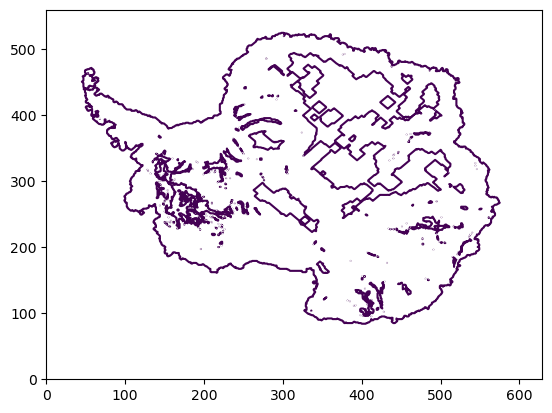

In [4]:
sc = plt.contour(zice, levels=[-.01])
# plt.xlim(360,410)
# plt.ylim(65,85)

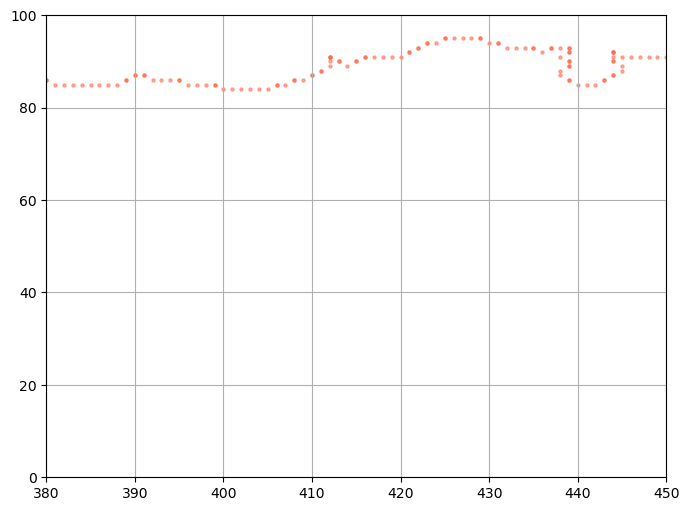

In [6]:
fig = plt.figure(figsize = (8, 6))
count = 0
x_contour = []
y_contour = []

# Create the contour:
# sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        
        count += 1
        
        if count == 1:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

xi=0
xf=3244
plt.scatter(x_contour[xi:xf], y_contour[xi:xf], s=5, alpha=0.5, color='tomato');
plt.xlim(380,450)
plt.ylim(0,100)
plt.grid('on')

In [7]:
xf-xi
# cut only circum-antarctic contour:
x_contour = x_contour[xi:xf]
y_contour = y_contour[xi:xf]


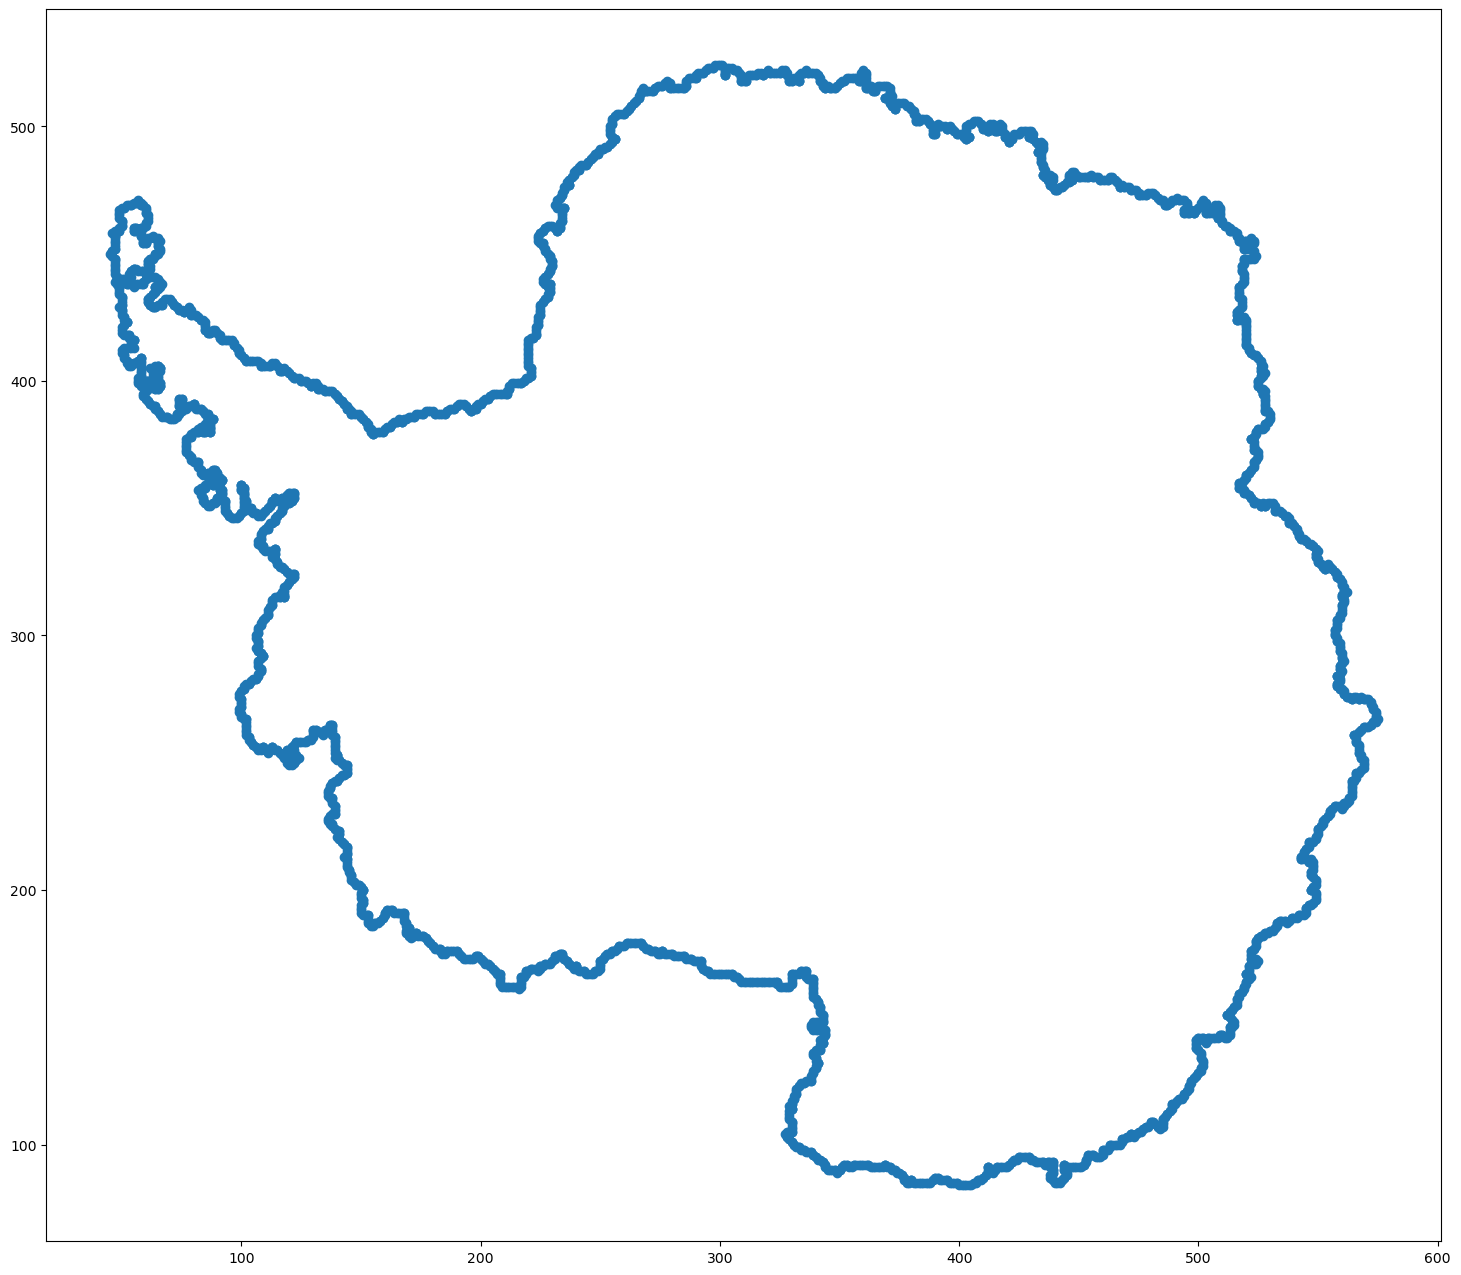

In [8]:

fig = plt.figure(figsize = (18, 16))

# plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='k');#tomato');
plt.plot(x_contour, y_contour,'o')
# plt.ylim(350,520)
# plt.xlim(0,100)
# plt.xlim(300,450)
# plt.ylim(50,100)
# plt.xlim(260,410)
# plt.ylim(65,150)

In [9]:
# save x_contour, y_contour

xcon_np = np.asarray(x_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_CF_x_contour.csv", xcon_np, delimiter=",")

ycon_np = np.asarray(y_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_CF_y_contour.csv", ycon_np, delimiter=",")


In [10]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'
xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_CF_x_contour.csv")
x_contour = xcon_np.tolist()
ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_CF_y_contour.csv")
y_contour = ycon_np.tolist()

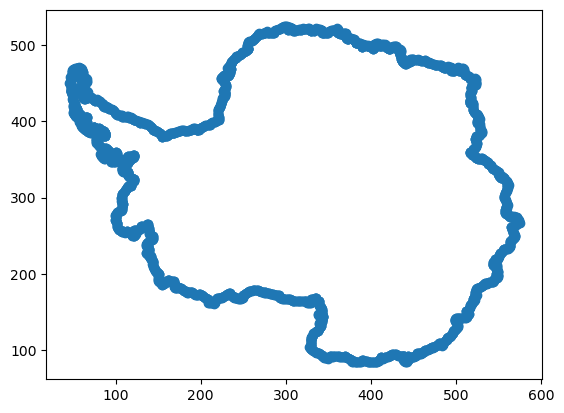

In [11]:
# plt.plot(x_contour,y_contour,'o')
plt.plot(xcon_np,ycon_np,'o')

# plt.xlim(1000,1100)
# plt.ylim(0,300)

#### calculate vol_transp here for testing - are the cross-contour transports correct?


In [12]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[int(y_contour[ii]), int(x_contour[ii])]

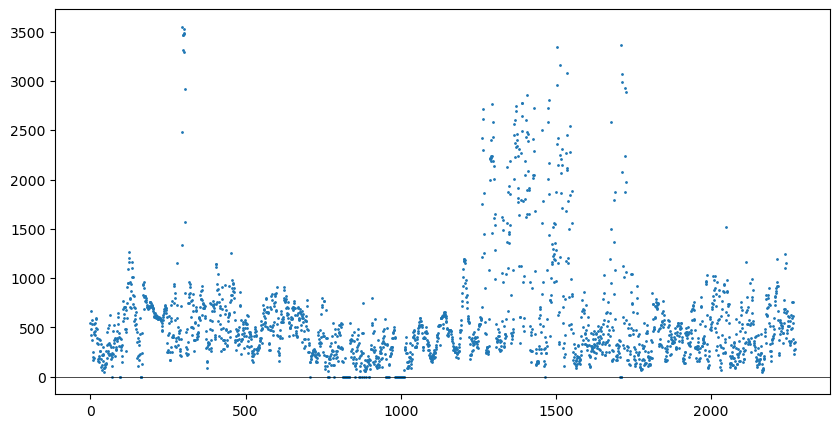

In [13]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [14]:
# Get lat/lon along the contour

# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[int(y_contour[ii-1]),int(x_contour[ii-1])]
    lat_along_contour[ii] = y_var[int(y_contour[ii-1]),int(x_contour[ii-1])]

# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)

lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

contour_mask = h*0

In [15]:
for ii in range(num_points-1):
    contour_mask[int(y_contour[ii]), int(x_contour[ii])] = contour_mask_numbered[ii]+1
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

#Create mask
#Now we create a mask below contour sothat the direction of the contour can be determined

#Remark on computational inefficiency:
#Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.
#See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

print(contour_masked_above.shape, contour_mask_numbered.shape)
print(contour_masked_above[-20:-1, 0])

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

(560, 630) (560, 630)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
#from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if north of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

In [17]:
# save contour_masked_above
files_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
contour_masked_above.dump(files_path + 'WAOM10_contour_masked_above_CF_v3')

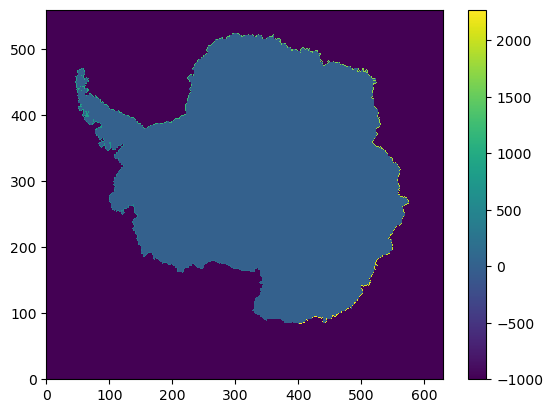

In [18]:
plt.pcolormesh(contour_masked_above)#, vmin=650, vmax=850)
plt.colorbar()
# plt.xlim(250,400)
# plt.ylim(0,150)

In [19]:
# Direction of cross-contour transport

mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos: add 2 extra columns with the value of the last/first columns of the original 
# Fabio Mar24: I don't think this is needed for ROMS; duplicating i/x coordinating (prob. for longitude gap propose?)
shape = contour_masked_above.shape
# contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
# contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
# contour_masked_above_halo[:, 1:-1] = contour_masked_above
# contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]


In [20]:
new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    
    # 1A) if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
        
    # 1B) if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
        
    # 1C) if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        mask_y_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2
        
    # 2A) if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above[index_j, index_i+1]==0) and (contour_masked_above[index_j, index_i-1]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
        
    # 2B) if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
        
    # 2C) if point to left and right BOTH toward Antarctica
    elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        mask_x_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2

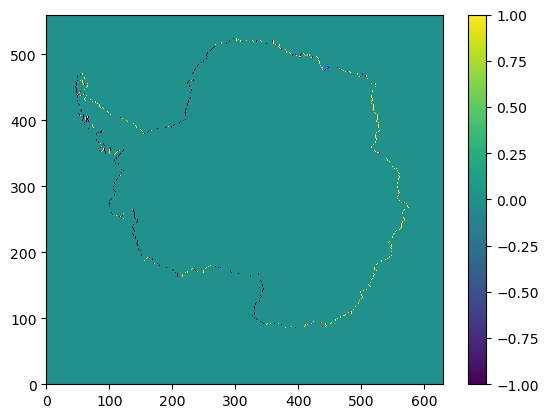

In [21]:
# checking masks x/y transport:


plt.pcolormesh(mask_x_transport)#, vmin=0, vmax=100)
plt.colorbar()
# plt.xlim(260,410)
# plt.ylim(65,150)
# plt.xlim(350,410)
# plt.ylim(60,90)
# plt.xlim(20,40)
# plt.ylim(420,440)

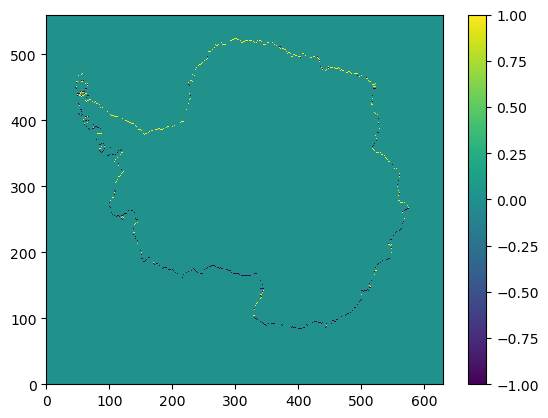

In [22]:
# checking masks x/y transport:

plt.pcolormesh(mask_y_transport)#, vmin=0, vmax=100)
plt.colorbar()
# plt.xlim(260,410)
# plt.ylim(65,150)
# plt.xlim(350,410)
# plt.ylim(60,90)
# plt.xlim(20,40)
# plt.ylim(420,440)

In [23]:
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

# save mask_x/y_transport for inspection;
coordinates=dict(lon=(['lon_rho','lat_rho'],dg.lon_rho.data), lat=(['lon_rho','lat_rho'], dg.lat_rho.data))
    
mask_x_transport_xr = xr.DataArray(mask_x_transport, coords = coordinates, dims = ['lon_rho','lat_rho'])
mask_y_transport_xr = xr.DataArray(mask_y_transport, coords = coordinates, dims = ['lon_rho','lat_rho'])

# rename vars:
mask_x_transport_xr.name = 'mask_x_transport'
mask_y_transport_xr.name = 'mask_y_transport'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross-CF_transp/'

mask_x_transport_xr.to_netcdf(files_path + 'mask_x_transport.nc', mode='w', format="NETCDF4")
mask_y_transport_xr.to_netcdf(files_path + 'mask_y_transport.nc', mode='w', format="NETCDF4")


In [24]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)

mask_x_transport = xr.DataArray(mask_x_transport, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = coordinates, dims = ['eta_rho', 'xi_rho'])

# rename dimensions as simply eta/xi
mask_x_transport = mask_x_transport.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_y_transport = mask_y_transport.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_x_transport_numbered = mask_x_transport_numbered.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_y_transport_numbered = mask_y_transport_numbered.rename({'eta_rho': 'eta','xi_rho': 'xi'})

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [25]:
# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.two
lon_along_contour = contour_ordering.one

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [26]:
# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=True, drop_variables=vars2drop, decode_times=False)

#- preserving daily avgs
temp = ds.variables["temp"]
salt = ds.variables["salt"]
shflux = ds.variables["shflux"]
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"]
Huon = ds.variables["Huon"]
ssh = ds.variables["zeta"]

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho - abs(ds.zice)
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w - abs(ds.zice)

ds.close()

Vtransform=2


In [27]:
%%time

## calculate heat transport and subtract Freezing point heat transport:

rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
# Tf = -1.95 # degC
Tf =  -3.534879684448242 # coldest temp along 1500m among all three WAOM expts (10km, 4km, 4km-notide)

# 1) multiply rho0*Cp:
HTv = HvomT*rho0*Cp
HTu = HuonT*rho0*Cp

# 2) calculate mean freezing point heat transport:
VTv_avg = Hvom.mean('ocean_time')
VTu_avg = Huon.mean('ocean_time')
HTf_v_avg = VTv_avg*Tf*rho0*Cp
HTf_u_avg = VTu_avg*Tf*rho0*Cp

# 3) subtract Tf HT from abs HT:
HTv = HTv - HTf_v_avg
HTu = HTu - HTf_u_avg

# 4) rename dimensions before multiplying for mask_x/y_transport:
# convert to DataArray first:
HTv = xr.DataArray(HTv)
HTu = xr.DataArray(HTu)
HTv = HTv.rename({'eta_v': 'eta','xi_v': 'xi'})
HTu = HTu.rename({'eta_u': 'eta','xi_u': 'xi'})

# 4) multiply mask_x/y_transport:
# for tt in range(0,365):
#     for kk in range(0,31):
        # HTv[tt,kk,:,:] = HTv[tt,kk,:,:]*mask_y_transport[:-1,:]
        # HTu[tt,kk,:,:] = HTu[tt,kk,:,:]*mask_x_transport[:,:-1]
HTvm = HTv*mask_y_transport[:-1,:]
HTum = HTu*mask_x_transport[:,:-1]

print(HTv.shape, HTu.shape)


(365, 31, 559, 630) (365, 31, 560, 629)
CPU times: user 41.9 ms, sys: 19.8 ms, total: 61.7 ms
Wall time: 55.2 ms


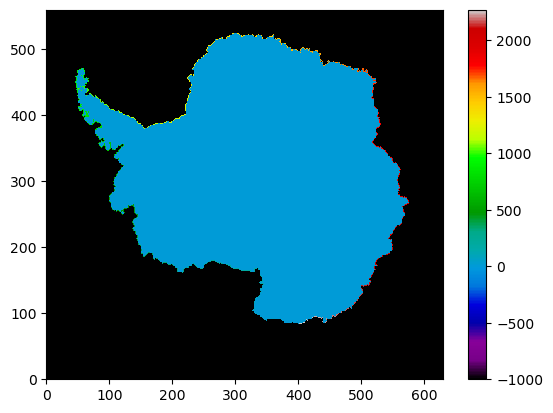

In [28]:
plt.pcolormesh(contour_masked_above, cmap='nipy_spectral')#, vmin=1000, vmax=2700)
plt.colorbar()
# plt.xlim(250,400)
# plt.ylim(0,150)


# create mask for cont. shelf budget:
mask_shelfc = ma.masked_where(contour_masked_above == -1000, np.ones(h.shape))

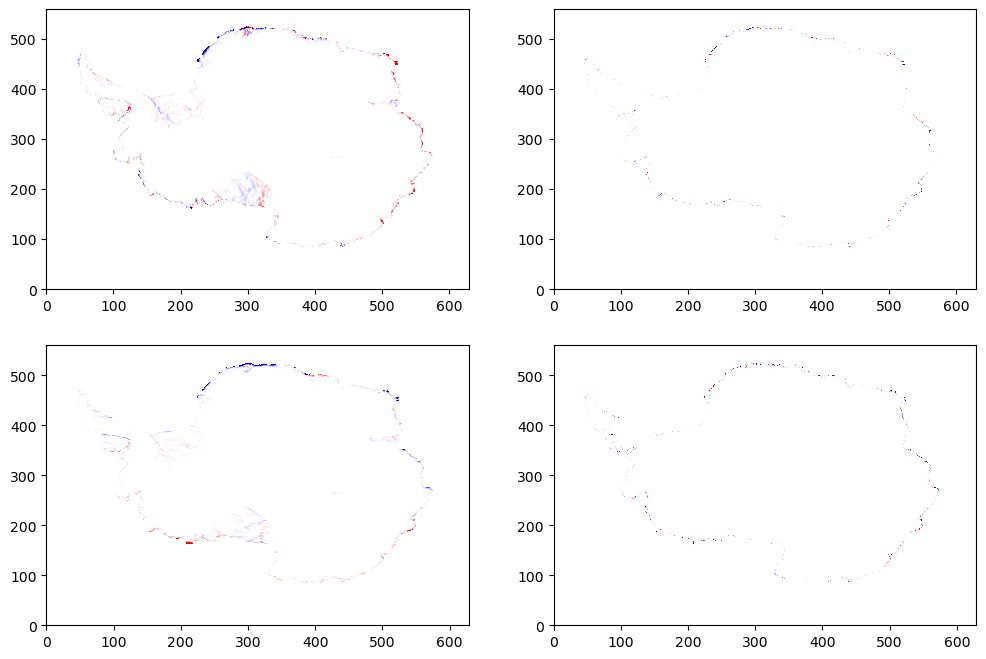

In [29]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

axs[0,0].pcolormesh(HTv.sum('s_rho').mean('ocean_time').values*mask_shelfc[:-1,:]*1e-12,  vmin=-3, vmax=3, cmap='bwr')

axs[0,1].pcolormesh(HTvm.sum('s_rho').mean('ocean_time')*1e-12, vmin=-3, vmax=3, cmap='bwr')

axs[1,0].pcolormesh(HTu.sum('s_rho').mean('ocean_time').values*mask_shelfc[:,:-1]*1e-12, vmin=-5, vmax=5, cmap='bwr')

axs[1,1].pcolormesh(HTum.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
# plt.colorbar()



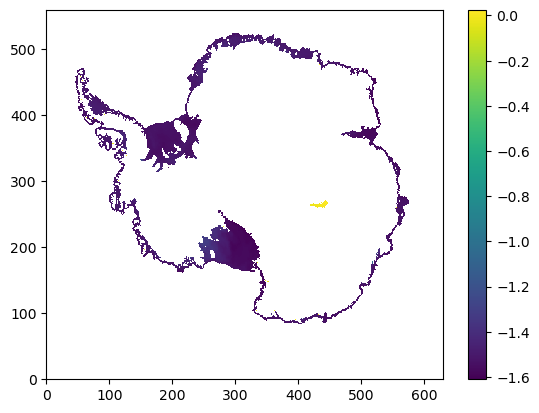

In [30]:
plt.pcolormesh(ssh.mean('ocean_time').values*mask_shelfc)#, vmin=650, vmax=850)
plt.colorbar()
# plt.xlim(250,400

In [31]:
ssh_annual = ssh.mean('ocean_time').values*mask_shelfc
print(ssh_annual.shape)
ssh_ts = ssh.values*mask_shelfc
ssh_sum = np.nansum(np.nansum(ssh_annual, axis=1), axis=0)
ssh_avg = np.nanmean(np.nanmean(ssh_annual, axis=1), axis=0)
ssh_avg_ts = np.nanmean(np.nanmean(ssh_ts, axis=2), axis=1)

(560, 630)


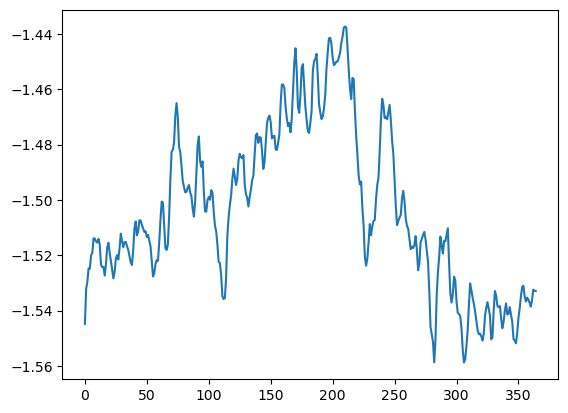

In [32]:
plt.plot(ssh_avg_ts)#, vmin=650, vmax=850)


In [33]:
# convert temp to DataArray to extract values along contour:
months=np.arange(0,365)*(1/30.41667)

# Convert heat transport to data arrays:
coordinates3Du = dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_u=(['eta_u'], np.arange(0,560)), xi_u=(['xi_u'], np.arange(0,629)))
coordinates3Dv = dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_v=(['eta_v'], np.arange(0,559)), xi_v=(['xi_v'], np.arange(0,630)))

# - handling x/y transports (Hvom, Huon [m3.s-1]) to calculate heat transport
Huon_xr = xr.DataArray(Huon, coords = coordinates3Du, dims = ['ocean_time','s_rho','eta_u', 'xi_u'])
Hvom_xr = xr.DataArray(Hvom, coords = coordinates3Dv, dims = ['ocean_time','s_rho','eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
Huon_xr = Huon_xr.rename({'eta_u': 'eta','xi_u': 'xi'})
Hvom_xr = Hvom_xr.rename({'eta_v': 'eta','xi_v': 'xi'})


In [47]:
%%time
## repeat for annual mean to check with Claire's example:

# defin function to extract any 4D var along the contour line

def extract_transp_across_contour_tavg(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[0,:,0,0])
    print(zlen)
    transp_across_contour = np.empty((zlen,len(contour_ordering)))

    for zz in range(0,zlen): # loop through z-levels
 
        # var_x_tmp = var_x[zz,:,:]*mask_x_transport[:,:-1] # the bug fixed in the -40Sv Vol transport came from here;
        # var_y_tmp = var_y[zz,:,:]*mask_y_transport[:-1,:] # the mask_x/y_transport are thought based on the staggeering grid alreadry
                                                          # (double-check for converting from B-Grid to C-Grid [Fabio, Mar24])   
                                                          # so the interpol. to u/v grid (done before) weren't necessary; they actually
                                                          # messed up the fluxes in a way that the circum-Ant. integral weren't Zero.
        var_x_tmp = var_x[zz,:,:]
        var_y_tmp = var_y[zz,:,:]

        
        # stack transports into 1d and drop any points not on contour:
        x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
        x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
        y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
        y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

        # combine all points on contour:
        transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
        transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
        transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
        transp_across_contour_tmp.coords['contour_index'] = contour_index_array
        transp_across_contour_tmp = transp_across_contour_tmp.load()

        print(zz, transp_across_contour_tmp.shape)
        transp_across_contour[zz,:] = transp_across_contour_tmp
        del transp_across_contour_tmp

    return transp_across_contour

# extract variables:
# 1. vol transp
# vol_trans_across_contour_tavg = extract_transp_across_contour_tavg(Huon_xr.mean('ocean_time')*mask_x_transport[:,:-1], Hvom_xr.mean('ocean_time')*mask_y_transport[:-1,:])

# new attempt by calculating HvomT/HuonT -  Tf HT before extracting transport along contour:
heat_trans_across_contour_tavg = extract_transp_across_contour_tavg(HTum.mean('ocean_time'), HTvm.mean('ocean_time'))
  

31
0 (3298,)
1 (3298,)
2 (3298,)
3 (3298,)
4 (3298,)
5 (3298,)
6 (3298,)
7 (3298,)
8 (3298,)
9 (3298,)
10 (3298,)
11 (3298,)
12 (3298,)
13 (3298,)
14 (3298,)
15 (3298,)
16 (3298,)
17 (3298,)
18 (3298,)
19 (3298,)
20 (3298,)
21 (3298,)
22 (3298,)
23 (3298,)
24 (3298,)
25 (3298,)
26 (3298,)
27 (3298,)
28 (3298,)
29 (3298,)
30 (3298,)
CPU times: user 6min, sys: 3min 22s, total: 9min 22s
Wall time: 20min 14s


In [35]:
def extract_tracer_along_contour_tavg(var):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[0,:,0,0])
    print(zlen)
    tracer_along_contour = np.empty((zlen,len(contour_ordering)))

    for zz in range(0,zlen): # loop through z-levels
 
        var_tmp = var[zz,:,:]
        
        # stack transports into 1d and drop any points not on contour:
        x_var_1d_tmp = var_tmp.stack(contour_index = ['eta', 'xi'])
        x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
        y_var_1d_tmp = var_tmp.stack(contour_index = ['eta', 'xi'])
        y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

        # combine all points on contour:
        tracer_along_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
        tracer_along_contour_tmp = tracer_along_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
        tracer_along_contour_tmp = tracer_along_contour_tmp.sortby(contour_ordering)
        tracer_along_contour_tmp.coords['contour_index'] = contour_index_array
        tracer_along_contour_tmp = tracer_along_contour_tmp.load()

        print(zz, tracer_along_contour_tmp.shape)
        tracer_along_contour[zz,:] = tracer_along_contour_tmp
        del tracer_along_contour_tmp

    return tracer_along_contour

# convert temp to DataArray to extract values along contour:
months=np.arange(0,365)*(1/30.41667)
coordinatesT=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))
temp_xr = xr.DataArray(temp, coords = coordinatesT, dims = ['ocean_time','s_rho','eta_rho', 'xi_rho'])
# rename dimensions as simply eta/xi
temp_xr = temp_xr.rename({'eta_rho': 'eta','xi_rho': 'xi'})

# extract variables:
temp_along_contour_tavg = extract_tracer_along_contour_tavg(temp_xr.mean('ocean_time'))



31
0 (3298,)
1 (3298,)
2 (3298,)
3 (3298,)
4 (3298,)
5 (3298,)
6 (3298,)
7 (3298,)
8 (3298,)
9 (3298,)
10 (3298,)
11 (3298,)
12 (3298,)
13 (3298,)
14 (3298,)
15 (3298,)
16 (3298,)
17 (3298,)
18 (3298,)
19 (3298,)
20 (3298,)
21 (3298,)
22 (3298,)
23 (3298,)
24 (3298,)
25 (3298,)
26 (3298,)
27 (3298,)
28 (3298,)
29 (3298,)
30 (3298,)


In [37]:
# define dist and z coordinates for pcolormesh plot:
expt='WAOM10'
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_CF_v3')
dist_along_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_CF_daily_v3')
z_rho_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_CF_v3')
distance_indices_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

[dist_along_axis_10km, Zaxis_10km] = np.meshgrid(dist_along_10km, np.arange(0,31))


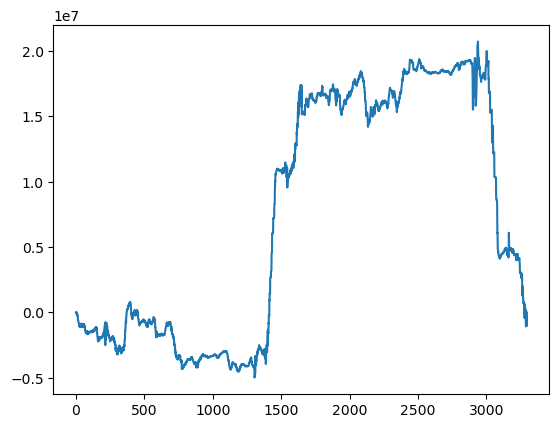

In [44]:
plt.plot(np.cumsum(np.nansum(vol_trans_across_contour_tavg, axis=0),axis=-1))

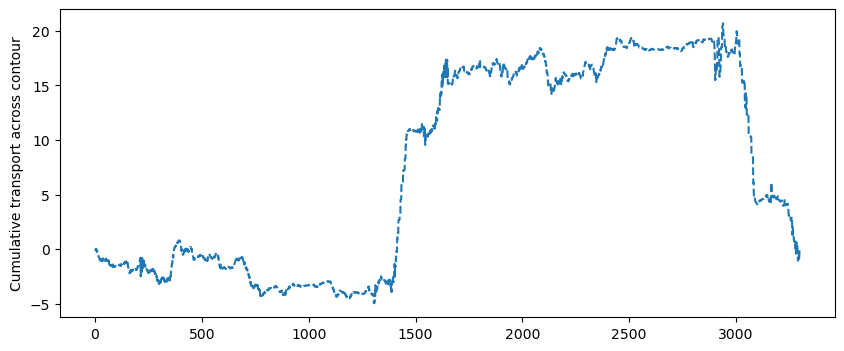

In [45]:
# plot Volume transport:

fig, ax = plt.subplots(figsize = (10, 4))

# plt.plot(np.cumsum(np.sum(np.nanmean(vol_trans_across_contour, axis=0), axis=0), axis=0))
plt.plot(np.cumsum(np.nansum(vol_trans_across_contour_tavg, axis=0), axis=0)*1e-6,'--')
# plt.plot(np.sum(vol_trans_across_contour_tavg, axis=0),'--')
# plt.plot(np.zeros(len(vol_trans_across_contour_tavg[0,:])),'--')
ax.set_ylabel('Cumulative transport across contour');


In [48]:
# calculate Tf heat transport
Tf_heat_transport = vol_trans_across_contour_tavg*Tf*rho0*Cp

# calculate mean eddy
mean_ht = vol_trans_across_contour_tavg*(temp_along_contour_tavg-Tf)*rho0*Cp

print(mean_ht.shape, heat_trans_across_contour_tavg.shape)


(31, 3298) (31, 3298)


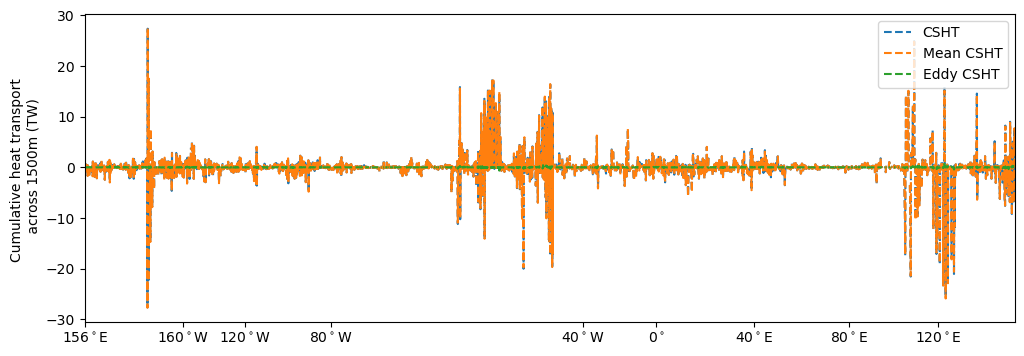

In [50]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'

fig, ax = plt.subplots(figsize = (12, 4))
plt.plot(dist_along_10km,np.divide(np.sum(heat_trans_across_contour_tavg, axis=0),1)*1e-12,'--', label='CSHT') # divide by 1000
plt.plot(dist_along_10km,np.divide(np.sum(mean_ht, axis=0),1)*1e-12,'--', label='Mean CSHT')
# plt.plot(dist_along_10km,-np.divide(np.sum(Tf_heat_transport, axis=0),1)*1e-12,'--',label='Tf HT x(-1)')
plt.plot(dist_along_10km,np.divide(np.sum(heat_trans_across_contour_tavg-mean_ht, axis=0),1)*1e-12,'--', label='Eddy CSHT')

ax.set_ylabel('Cumulative heat transport \n across 1500m (TW)');
plt.legend()
# plt.ylim(-500,2500)

ax.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax.set_xlim(0, dist_along_10km[-1])
# ax.set_aspect('auto')
ax.tick_params(labelsize=10)

plt.savefig(fig_path + 'WAOM10_Cross-CF_vint_NonCumsum_MeanEddy_v4.png', bbox_inches='tight', dpi=300)
plt.show()

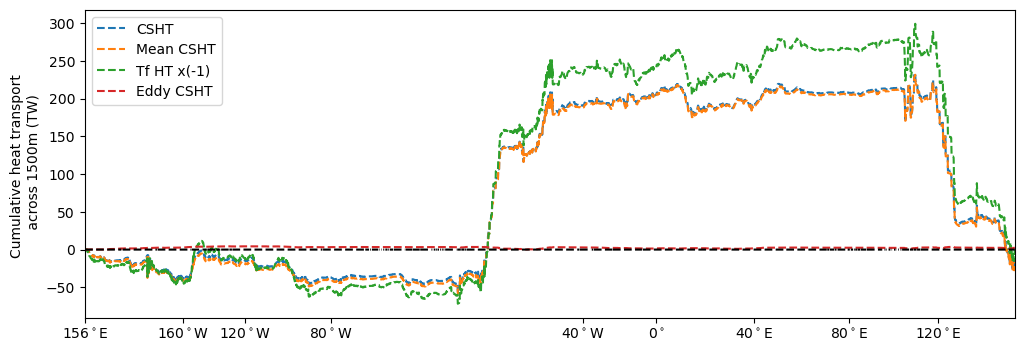

In [54]:

fig, ax = plt.subplots(figsize = (12, 4))

plt.plot(dist_along_10km,np.cumsum(np.divide(np.nansum(heat_trans_across_contour_tavg, axis=0),1), axis=0)*1e-12,'--', label='CSHT')
plt.plot(dist_along_10km,np.cumsum(np.divide(np.nansum(mean_ht, axis=0),1), axis=0)*1e-12,'--', label='Mean CSHT')
plt.plot(dist_along_10km,-np.cumsum(np.divide(np.nansum(Tf_heat_transport, axis=0),1), axis=0)*1e-12,'--',label='Tf HT x(-1)')
plt.plot(dist_along_10km,np.cumsum(np.divide(np.nansum(heat_trans_across_contour_tavg-mean_ht, axis=0),1), axis=0)*1e-12,'--', label='Eddy CSHT')
plt.plot(dist_along_10km,np.sum(mean_ht, axis=0)*0,'--k')
ax.set_ylabel('Cumulative heat transport \n across 1500m (TW)');
plt.legend()
# plt.ylim(-500,2500)

ax.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax.set_xlim(0, dist_along_10km[-1])
# ax.set_aspect('auto')
ax.tick_params(labelsize=10)

plt.savefig(fig_path + 'WAOM10_Cross-CF_vint_MeanEddy_Tf_v4.png', bbox_inches='tight', dpi=300)
plt.show()